In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import models
import torch
from torchvision.transforms import transforms
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
import pandas as pd
import os
from tqdm import tqdm

# Testing the trained models

In this notebook, the trained models are used to generate deblurred images from the test data and the chosen metrics (psnr and ssim) are calculated and saved in csv files. The trained models are loaded and the test data is passed through the models to generate the deblurred images. The deblurred images are then saved to a folder. 

- the trained models can be found in the folder **../outputs**
- the test data is in the folder **../data/test_data**
- the deblurred images are then saved in the folder **../outputs/test_deblurred_images**
- the csv files containing the psnr and ssim values are saved in the folder **../results**

In [18]:
# Function to save the decoded image
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

# Function to calculate the SSIM value
def calc_ssim_rgb(im1, im2):
    first_ssim = ssim(im1[:,:,0], im2[:,:,0], data_range=im1[:,:,0].max() - im1[:,:,0].min())
    second_ssim = ssim(im1[:,:,1], im2[:,:,1], data_range=im1[:,:,1].max() - im1[:,:,1].min())
    third_ssim = ssim(im1[:,:,2], im2[:,:,2], data_range=im1[:,:,2].max() - im1[:,:,2].min())
    return (first_ssim + second_ssim + third_ssim) / 3

# Function to calculate the PSNR value
def PSNR(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:
        return 100
    max_pixel = original.shape[0]*original.shape[1]
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

#### 1. Test of model trained on the original dataset

In the training notebook training_colab.ipynb, the data is split into train, validation and test set. The model is trained on the train set and the validation set is used to monitor the training process. The test set is not used in the training process. The image names from the test set are saved in test_set_orig_dataset.txt. Here the model is tested on the test images from this txt file containing the test image names.

In [19]:
file_path = "../data/test_data/sharp/original_dataset/test_set_orig_dataset.txt"

with open(file_path, 'r') as file:
    test_images = [line.strip() for line in file]

In [20]:
device = 'cpu'

# load the trained model
model = models.CNN().to(device).eval()
model.load_state_dict(torch.load('../outputs/model_original_dataset.pth', map_location=torch.device('cpu')))

# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [21]:
# Deblur the images from the test set and save them
for name in test_images:
    image = cv2.imread(f"../data/train_data/gaussian_blurred/original_dataset/{name}")
    orig_image = image.copy()
    orig_image = cv2.resize(orig_image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        save_decoded_image(outputs.cpu().data, name=f"../data/test_data/deblurred/original_dataset/deblurred_{name}")


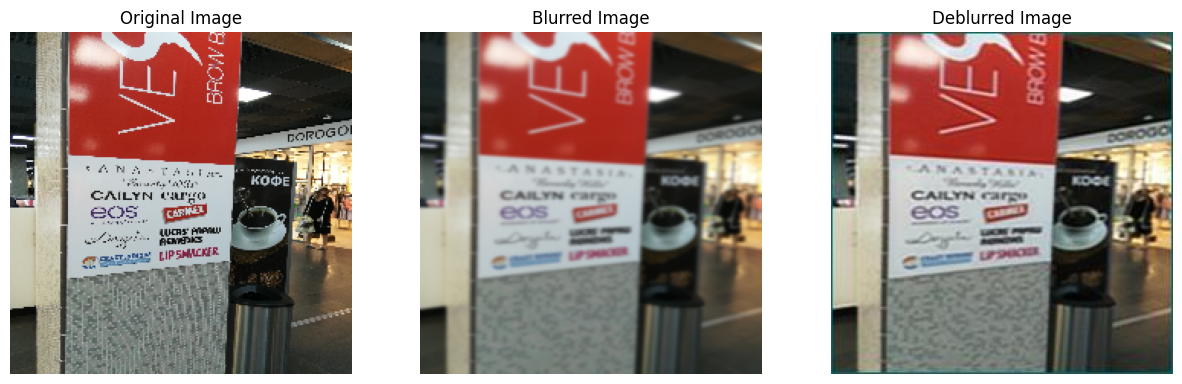

In [22]:
# Create dataframes to store the SSIM and PSNR values
ssim_df = pd.DataFrame()
psnr_df = pd.DataFrame()

i = 0
# Calculate the SSIM and PSNR values
for file in test_images:

    orig_image = plt.imread(f"../data/train_data/sharp/original_dataset/{file}")
    blur_image = plt.imread(f"../data/train_data/gaussian_blurred/original_dataset/{file}")
    deblur_image = plt.imread(f"../data/test_data/deblurred/original_dataset/deblurred_{file}")
        
    orig_image = cv2.resize(orig_image, (224, 224))
    blur_image = cv2.resize(blur_image, (224, 224))
    deblur_image = cv2.resize(deblur_image, (224, 224))
   
    ssim_tmp = pd.DataFrame({'Image': file,
                             'SSIM btw Original and Blur': [calc_ssim_rgb(orig_image, blur_image)],
                             'SSIM btw Original and Deblurred': [calc_ssim_rgb(orig_image, deblur_image)],
                             'SSIM btw Blur and Deblurred': [calc_ssim_rgb(blur_image, deblur_image)]})
    psnr_tmp = pd.DataFrame({'Image': file,
                             'PSNR btw Original and Blur': [PSNR(orig_image, blur_image)],
                             'PSNR btw Original and Deblurred': [PSNR(orig_image, deblur_image)],
                             'PSNR btw Blur and Deblurred': [PSNR(blur_image, deblur_image)]})
    
    ssim_df = pd.concat([ssim_df, ssim_tmp], ignore_index=True)
    psnr_df = pd.concat([psnr_df, psnr_tmp], ignore_index=True)

    # Plot 1 of the deblurred test images
    if i == 0:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(orig_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(blur_image)
        plt.title('Blurred Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(deblur_image)
        plt.title('Deblurred Image')
        plt.axis('off')

        plt.show()

    i += 1


In [23]:
ssim_df.to_csv("../results/ssim_original_dataset.csv", index=False)
psnr_df.to_csv("../results/psnr_original_dataset.csv", index=False)
psnr_df

,Image,PSNR btw Original and Blur,PSNR btw Original and Deblurred,PSNR btw Blur and Deblurred
0,241_HONOR-7X_S.jpg,76.952274,76.242449,77.594430
1,92_IPHONE-7_S.jpeg,82.847893,80.525774,81.917745
2,69_SAMSUNG-GALAXY-J3_S.jpg,78.058004,77.413447,78.275920
3,310_XIAOMI-PROCOFONE-F1_S.jpg,78.304492,77.293906,78.555903
4,23_HUAWEI-P20_S.jpg,75.288927,75.283940,77.257026
...,...,...,...,...
65,185_HONOR-6X_S.jpg,75.789957,75.711829,78.798453
66,263_XIAOMI-REDMI-3S_S.jpg,77.678246,77.307459,79.014525
67,261_HONOR-10_S.jpg,75.111423,74.982388,77.697569
68,27_HONOR-8X_S.jpg,81.486258,79.278771,80.592546


#### 2. Test of CNN model trained on the chosen dataset - Gaussian Blur 51x51

In [24]:
device = 'cpu'

# load the trained model
model = models.CNN().to(device).eval()
model.load_state_dict(torch.load('../outputs/model_chosen_dataset_51x51.pth', map_location=torch.device('cpu')))

# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

src_dir = '../data/test_data/sharp/chosen_dataset'
test_images = os.listdir(src_dir)

# Deblur the images from the test set and save them
for name in test_images:
    image = cv2.imread(f"../data/test_data/gaussian_blurred/chosen_dataset_51x51/{name}")
    orig_image = image.copy()
    orig_image = cv2.resize(orig_image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        save_decoded_image(outputs.cpu().data, name=f"../data/test_data/deblurred/chosen_dataset_51x51/deblurred_{name}")


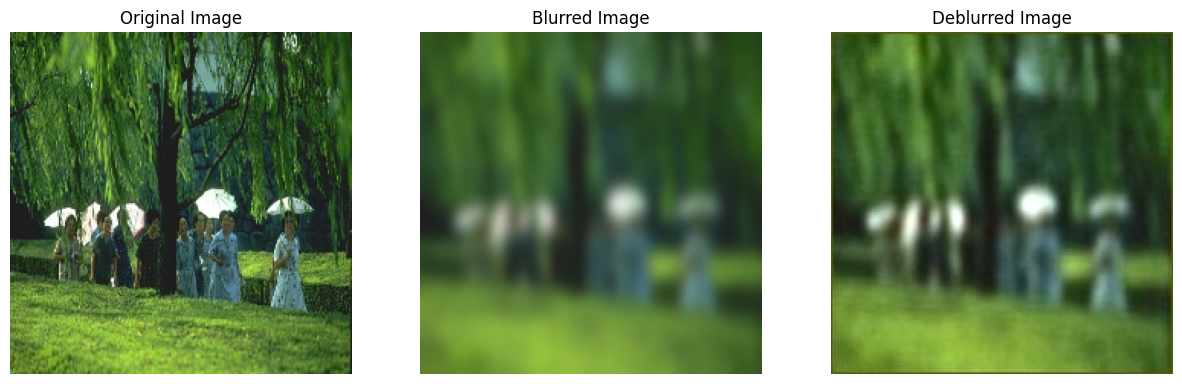

In [25]:
# Create dataframes to store the SSIM and PSNR values
ssim_df = pd.DataFrame()
psnr_df = pd.DataFrame()

i = 0

# Calculate the SSIM and PSNR values
for file in test_images:
    orig_image = plt.imread(f"../data/test_data/sharp/chosen_dataset/{file}")
    blur_image = plt.imread(f"../data/test_data/gaussian_blurred/chosen_dataset_51x51/{file}")
    deblur_image = plt.imread(f"../data/test_data/deblurred/chosen_dataset_51x51/deblurred_{file}")
        
    orig_image = cv2.resize(orig_image, (224, 224))
    blur_image = cv2.resize(blur_image, (224, 224))
    deblur_image = cv2.resize(deblur_image, (224, 224))
   
    ssim_tmp = pd.DataFrame({'Image': file,
                             'SSIM btw Original and Blur': [calc_ssim_rgb(orig_image, blur_image)],
                             'SSIM btw Original and Deblurred': [calc_ssim_rgb(orig_image, deblur_image)],
                             'SSIM btw Blur and Deblurred': [calc_ssim_rgb(blur_image, deblur_image)]})
    psnr_tmp = pd.DataFrame({'Image': file,
                             'PSNR btw Original and Blur': [PSNR(orig_image, blur_image)],
                             'PSNR btw Original and Deblurred': [PSNR(orig_image, deblur_image)],
                             'PSNR btw Blur and Deblurred': [PSNR(blur_image, deblur_image)]})
    
    ssim_df = pd.concat([ssim_df, ssim_tmp], ignore_index=True)
    psnr_df = pd.concat([psnr_df, psnr_tmp], ignore_index=True)

    # Plot 1 of the deblurred test images
    if i == 0:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(orig_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(blur_image)
        plt.title('Blurred Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(deblur_image)
        plt.title('Deblurred Image')
        plt.axis('off')

        plt.show()

    i += 1

In [26]:
ssim_df.to_csv("../results/ssim_chosen_dataset_51x51.csv", index=False)
psnr_df.to_csv("../results/psnr_chosen_dataset_51x51.csv", index=False)
psnr_df

,Image,PSNR btw Original and Blur,PSNR btw Original and Deblurred,PSNR btw Blur and Deblurred
0,65033.jpg,74.754895,74.885141,76.939081
1,148089.jpg,74.387288,74.551365,76.338519
2,21077.jpg,75.419386,75.611718,76.583738
3,41033.jpg,75.878830,76.303776,77.812760
4,12084.jpg,74.910634,74.726403,77.774102
...,...,...,...,...
95,24077.jpg,74.771111,75.015062,75.406298
96,126007.jpg,77.002734,76.667396,77.898387
97,304034.jpg,74.323170,74.447727,76.143453
98,170057.jpg,75.749764,75.782362,77.543666


#### 3. Test of the CNN model trained on the chosen dataset - Gaussian Blur 15x15

In [27]:
device = 'cpu'

# load the trained model
model = models.CNN().to(device).eval()
model.load_state_dict(torch.load('../outputs/model_chosen_dataset_15x15.pth', map_location=torch.device('cpu')))

# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

src_dir = '../data/test_data/sharp/chosen_dataset'
test_images = os.listdir(src_dir)

# Deblur the images from the test set and save them
for name in test_images:
    image = cv2.imread(f"../data/test_data/gaussian_blurred/chosen_dataset_15x15/{name}")
    orig_image = image.copy()
    orig_image = cv2.resize(orig_image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        save_decoded_image(outputs.cpu().data, name=f"../data/test_data/deblurred/chosen_dataset_15x15/deblurred_{name}")



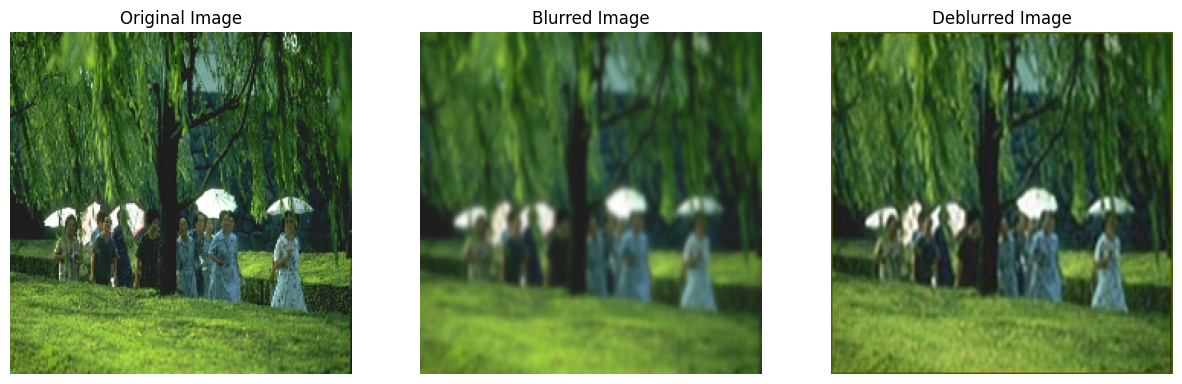

In [28]:
# Create dataframes to store the SSIM and PSNR values
ssim_df = pd.DataFrame()
psnr_df = pd.DataFrame()

i= 0

# Calculate the SSIM and PSNR values
for file in test_images:

    orig_image = plt.imread(f"../data/test_data/sharp/chosen_dataset/{file}")
    blur_image = plt.imread(f"../data/test_data/gaussian_blurred/chosen_dataset_15x15/{file}")
    deblur_image = plt.imread(f"../data/test_data/deblurred/chosen_dataset_15x15/deblurred_{file}")
        
    orig_image = cv2.resize(orig_image, (224, 224))
    blur_image = cv2.resize(blur_image, (224, 224))
    deblur_image = cv2.resize(deblur_image, (224, 224))
   
    ssim_tmp = pd.DataFrame({'Image': file,
                             'SSIM btw Original and Blur': [calc_ssim_rgb(orig_image, blur_image)],
                             'SSIM btw Original and Deblurred': [calc_ssim_rgb(orig_image, deblur_image)],
                             'SSIM btw Blur and Deblurred': [calc_ssim_rgb(blur_image, deblur_image)]})
    psnr_tmp = pd.DataFrame({'Image': file,
                             'PSNR btw Original and Blur': [PSNR(orig_image, blur_image)],
                             'PSNR btw Original and Deblurred': [PSNR(orig_image, deblur_image)],
                             'PSNR btw Blur and Deblurred': [PSNR(blur_image, deblur_image)]})
    
    ssim_df = pd.concat([ssim_df, ssim_tmp], ignore_index=True)
    psnr_df = pd.concat([psnr_df, psnr_tmp], ignore_index=True)

    # Plot 1 of the deblurred test images
    if i == 0:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(orig_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(blur_image)
        plt.title('Blurred Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(deblur_image)
        plt.title('Deblurred Image')
        plt.axis('off')

        plt.show()

    i += 1


In [29]:
ssim_df.to_csv("../results/ssim_chosen_dataset_15x15.csv", index=False)
psnr_df.to_csv("../results/psnr_chosen_dataset_15x15.csv", index=False)
psnr_df

,Image,PSNR btw Original and Blur,PSNR btw Original and Deblurred,PSNR btw Blur and Deblurred
0,65033.jpg,75.612148,75.603673,77.090880
1,148089.jpg,75.229707,75.455634,76.647502
2,21077.jpg,76.917393,77.020432,78.300450
3,41033.jpg,78.071298,78.297403,79.602715
4,12084.jpg,76.034132,75.852571,76.923488
...,...,...,...,...
95,24077.jpg,76.293924,76.684640,76.508519
96,126007.jpg,78.488134,78.070253,78.938653
97,304034.jpg,75.214949,75.668086,76.287546
98,170057.jpg,77.500837,77.815786,78.096033


#### 4. Test of the SimpleAE model trained on the chosen dataset - Gaussian Blur 15x15

In [30]:
device = 'cpu'

# load the trained model
model = models.SimpleAE().to(device).eval()
model.load_state_dict(torch.load('../outputs/model_berkeley_simpleae.pth', map_location=torch.device('cpu')))

# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

src_dir = '../data/test_data/sharp/chosen_dataset'
test_images = os.listdir(src_dir)

# Deblur the images from the test set and save them
for name in test_images:
    image = cv2.imread(f"../data/test_data/gaussian_blurred/chosen_dataset_15x15/{name}")
    orig_image = image.copy()
    orig_image = cv2.resize(orig_image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        save_decoded_image(outputs.cpu().data, name=f"../data/test_data/deblurred/chosen_dataset_simpleae/deblurred_{name}")

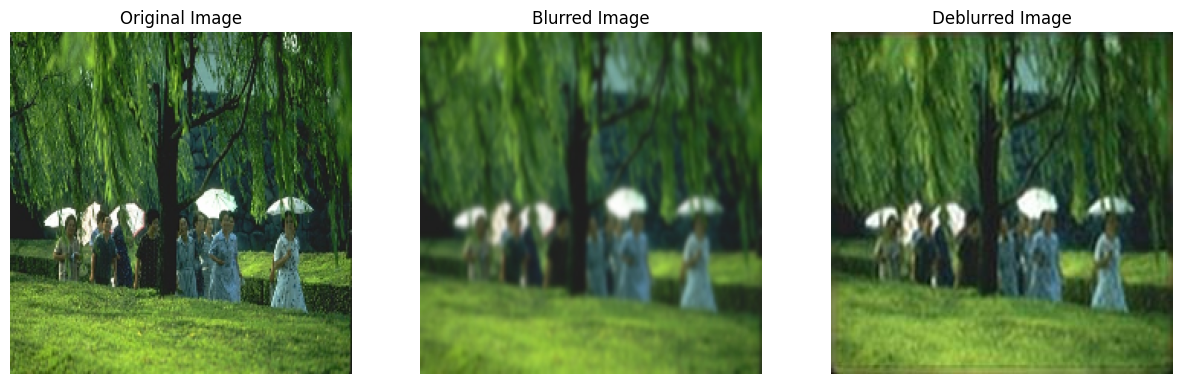

In [31]:
# Create dataframes to store the SSIM and PSNR values
ssim_df = pd.DataFrame()
psnr_df = pd.DataFrame()

i = 0

# Calculate the SSIM and PSNR values
for file in test_images:

    orig_image = plt.imread(f"../data/test_data/sharp/chosen_dataset/{file}")
    blur_image = plt.imread(f"../data/test_data/gaussian_blurred/chosen_dataset_15x15/{file}")
    deblur_image = plt.imread(f"../data/test_data/deblurred/chosen_dataset_simpleae/deblurred_{file}")
        
    orig_image = cv2.resize(orig_image, (224, 224))
    blur_image = cv2.resize(blur_image, (224, 224))
    deblur_image = cv2.resize(deblur_image, (224, 224))
   
    ssim_tmp = pd.DataFrame({'Image': file,
                             'SSIM btw Original and Blur': [calc_ssim_rgb(orig_image, blur_image)],
                             'SSIM btw Original and Deblurred': [calc_ssim_rgb(orig_image, deblur_image)],
                             'SSIM btw Blur and Deblurred': [calc_ssim_rgb(blur_image, deblur_image)]})
    psnr_tmp = pd.DataFrame({'Image': file,
                             'PSNR btw Original and Blur': [PSNR(orig_image, blur_image)],
                             'PSNR btw Original and Deblurred': [PSNR(orig_image, deblur_image)],
                             'PSNR btw Blur and Deblurred': [PSNR(blur_image, deblur_image)]})
    
    ssim_df = pd.concat([ssim_df, ssim_tmp], ignore_index=True)
    psnr_df = pd.concat([psnr_df, psnr_tmp], ignore_index=True)

    # Plot 1 of the deblurred test images
    if i == 0:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(orig_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(blur_image)
        plt.title('Blurred Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(deblur_image)
        plt.title('Deblurred Image')
        plt.axis('off')

        plt.show()

    i += 1

In [32]:
ssim_df.to_csv("../results/ssim_chosen_dataset_simpleae.csv", index=False)
psnr_df.to_csv("../results/psnr_chosen_dataset_simpleae.csv", index=False)
psnr_df

,Image,PSNR btw Original and Blur,PSNR btw Original and Deblurred,PSNR btw Blur and Deblurred
0,65033.jpg,75.612148,75.514534,77.450835
1,148089.jpg,75.229707,75.441012,77.045368
2,21077.jpg,76.917393,77.253612,78.798965
3,41033.jpg,78.071298,78.415358,80.472995
4,12084.jpg,76.034132,75.725125,77.057533
...,...,...,...,...
95,24077.jpg,76.293924,76.803194,76.847162
96,126007.jpg,78.488134,78.418311,79.834320
97,304034.jpg,75.214949,75.568599,76.712976
98,170057.jpg,77.500837,77.785151,78.597249
